In [2]:
%matplotlib inline
import math
import os 
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
import statsmodels.api as sm
from pandas import ExcelWriter
import pickle
import scipy as sp

In [3]:
def load_object(filename):
    with open(filename, 'rb') as fid:
        file = pickle.load(fid)
    return file

In [6]:
#Read the csv file and modify columns. Returns a dataframe
def tofread_csv(rawdata):
    #read csv file.
    data = pd.read_csv(rawdata, error_bad_lines=False)
    #rennaming 1st column as ID
    data = data.rename(index=str, columns={"Unnamed: 0": "ID"})
    #drop columns that have volume and size
    data = data[data.columns.drop(list(data.filter(regex='vol')))]
    data = data[data.columns.drop(list(data.filter(regex='size')))]
    data.columns = data.columns.str.replace('_mass_g','')
    return data

#non_zero_data drops rows that has a zero value in every isotope returning rows that have particle events. Should be ran first before starting other functions!
def non_zero_data(data):
    #data = data.drop(columns = "ID")
    non_zero_rows = data.abs().sum(axis=1) > 0.0
    non_zero_data = data[non_zero_rows]
    #non_zero_columns = non_zero_data.abs().sum(axis=0) > 0.0
    #non_zero_data = non_zero_data.loc[: , non_zero_columns]
    return non_zero_data

#wrap the tofread function
def wrapper(string, ELEMENTS = None):
    df = pd.DataFrame()
    #ELEMENTS = 4
    for i in glob.glob(string):
        df = pd.concat([tofread_csv(i), df], axis = 0, sort = False)
    df.drop(columns = ['Index', r'timestamp /s'], inplace = True)
    df.columns = df.columns.str.replace(r' /g', '')
    df.columns = df.columns.str.replace(r'[', '')
    df.columns = df.columns.str.replace('+', '')
    df.columns = df.columns.str.replace(']', '')
    if ELEMENTS != None:
        df.drop(columns = ELEMENTS, inplace = True)
    return non_zero_data(df)

import copy

#add noise to the data
def addnoise(df, noise, coefficient = None):
    if coefficient != None:
        df = df*coefficient
    df = df.fillna(0) + np.random.random(df.shape)*noise
    return df

#put multiple DFs together with the key
def combineddf(dflist, dfkeys, ELEMENTS, noise = None, coefficient = None,):
    #make an empty list
    combinedlist = []
    #make an empty dataframe
    combineddf12 = pd.DataFrame()

    for i,j in zip(dflist, dfkeys):
        if noise == None and coefficient == None:
            df = non_zero_data(i[ELEMENTS])
            #fillnan with 0
            df[np.isnan(df)] = 0
        else:
            #add noise
            df = addnoise(i[ELEMENTS], noise, coefficient)


        df['labels'] = j
        combinedlist.append(df)
        combineddf12 = pd.concat([combineddf12, df])
    return combineddf12

#return random projection codes for each sample
def flyprojection(data, keys, ELEMENTS, expansionfactor):
    data1 = combineddf(data, keys, ELEMENTS)
    sourcenorm = copy.deepcopy(data1.iloc[:,:-1][ELEMENTS])

    #had to center the mean like this because certain elements did not have any particle events for certain sources
    for i in ELEMENTS:
        sourcenorm[i] =sourcenorm[i].fillna(0)
        try:
            sourcenorm[i] = sourcenorm[i]/sourcenorm[i].mean(axis=0)
        except ValueError:
            continue
    sourcenorm = sourcenorm.fillna(0)  
    codes1 = encode(np.array(sourcenorm), expansionfactor)
    return codes1

#apply the cluster labels with corresponding max probability
def applylabels(data, keys, ELEMENTS, model, codes):
    data1 = combineddf(data, keys, ELEMENTS)
    labelstransform = model.transform(codes)
    data1['clusters'] = labelstransform.argmax(axis = 1)
    data1['clustersprob'] = labelstransform.max(axis = 1)
    return data1, labelstransform

In [4]:
#load the Sources
SourceDF, Sourceprob, Sourcekeys = load_object('models/revision/SourceDF_2.pkl')


In [5]:
#Load the model 

model2 = load_object('models/revision/LDAModel_2.pkl')

In [43]:
#load the extra source data

#import the data
DROPELEMENTS = ['28Si', '29Si', '56Fe', '24Mg', '25Mg', '27Al']

soildust_sample = wrapper('sample_data/externalv/particle_masses_Source1**', DROPELEMENTS)
condust_sample = wrapper('sample_data/externalv/particle_masses_Source2**', DROPELEMENTS)
condsand_sample = wrapper('sample_data/externalv/particle_masses_Source3**', DROPELEMENTS)
coalburning_sample = wrapper('sample_data/externalv/particle_masses_Source4**', DROPELEMENTS)
indemission_sample = wrapper('sample_data/externalv/particle_masses_Source5**', DROPELEMENTS)
urbanfugdust_sample = wrapper('sample_data/externalv/particle_masses_Source6**', DROPELEMENTS)
biomass_sample = wrapper('sample_data/externalv/particle_masses_Source7**', DROPELEMENTS)

Sourceexsamples = [soildust_sample, condust_sample, condsand_sample, coalburning_sample, indemission_sample, urbanfugdust_sample, biomass_sample]
Sourceexsamplekeys = ['Soil dust1', 'Construction dust1', 'Construction sand1', 'Coal burning1', 'Industrial emission1', 'Urban Fugitive Dust1', 'Biomass1']

ELEMENTS = ['48Ti', '52Cr', '55Mn', '54Fe', '59Co', '58Ni', '63Cu', '64Zn', '69Ga', '72Ge', '75As', '78Se', '85Rb', '88Sr', '89Y', '90Zr', '93Nb', 
           '98Mo', '108Pd', '107Ag', '114Cd', '120Sn', '121Sb', '130Te', '133Cs', '138Ba', '139La', '140Ce', '152Sm', '153Eu', '158Gd', '159Tb', '164Dy', '165Ho',
           '166Er', '169Tm', '174Yb', '175Lu', '180Hf', '181Ta', '185Re', '192Os', '193Ir', '195Pt', '197Au', '202Hg', '208Pb', '238U', '51V']

In [34]:
rng = np.random.default_rng()

d = len(ELEMENTS)  # number of features
expansion_factor = 128
m = expansion_factor * d  # dimension of the code space

def top_idx(a, k):
    """indices of the top k values of each row of a"""
    return np.argpartition(a, -k)[:, -k:]

def top_mask(a, k):
    """create a boolean matrix the same shape as a indicating the top k items of each row"""
    idx = top_idx(a, k)
    mask = np.zeros_like(a)
    row_idx = np.arange(len(a)).reshape(-1,1)
    mask[np.repeat(row_idx, k, axis=-1), idx] = 1
    return mask

# from the supplementary materials:
# A simple model of M is a sparse, binary random matrix:
# each entry M_ij is set independently with probability p. Choosingp= 6/d, for instance,
# would mean that each row of M has roughly 6 entries equal to 1 (and all of the other
# entries are 0), which matches experimental findings.
p = 8 / float(d)
# M is the random mapping from features to codes (in the supplementary materials it is a m x d matrix),
# here it is swapped so we can do data * M = codes where data is n samples x d and codes in n samples x m
M = (rng.random(size=(d, m)) < p).astype(np.uint8)

def encode(data, k):
    """Encode the data using random projection and winner take all approach """
    res = data @ M
    mask = top_mask(res, k)
    return res * mask

In [35]:
k = 9 # the k largest values of the code will be used as the result

In [36]:
#save object
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [44]:
Sourceexsamplecodes = flyprojection(Sourceexsamples, Sourceexsamplekeys, ELEMENTS, k)

In [45]:
Sourceexsamples, Sourceexsamplesprob =  applylabels(Sourceexsamples, Sourceexsamplekeys, ELEMENTS, model2, Sourceexsamplecodes)

# all Sources together

In [46]:
# add k-nearest neighbors

from sklearn import neighbors

clf = neighbors.KNeighborsClassifier(n_neighbors = 10)

clf.fit(Sourceprob, SourceDF['labels'])


Results = clf.predict(Sourceexsamplesprob)

Labels = Sourceexsamples['labels']

Sourceexsamples['results'] = Results

knearestneighborslist = []


#for every sample label, get the unique sources and counts associated based on k-nearest neighbor predictions
for i in Sourceexsamples['labels'].unique():
    knearestneighborslist.append([i, np.unique(np.array(Sourceexsamples[['results']][Sourceexsamples['labels'] == i]), return_counts = True)])

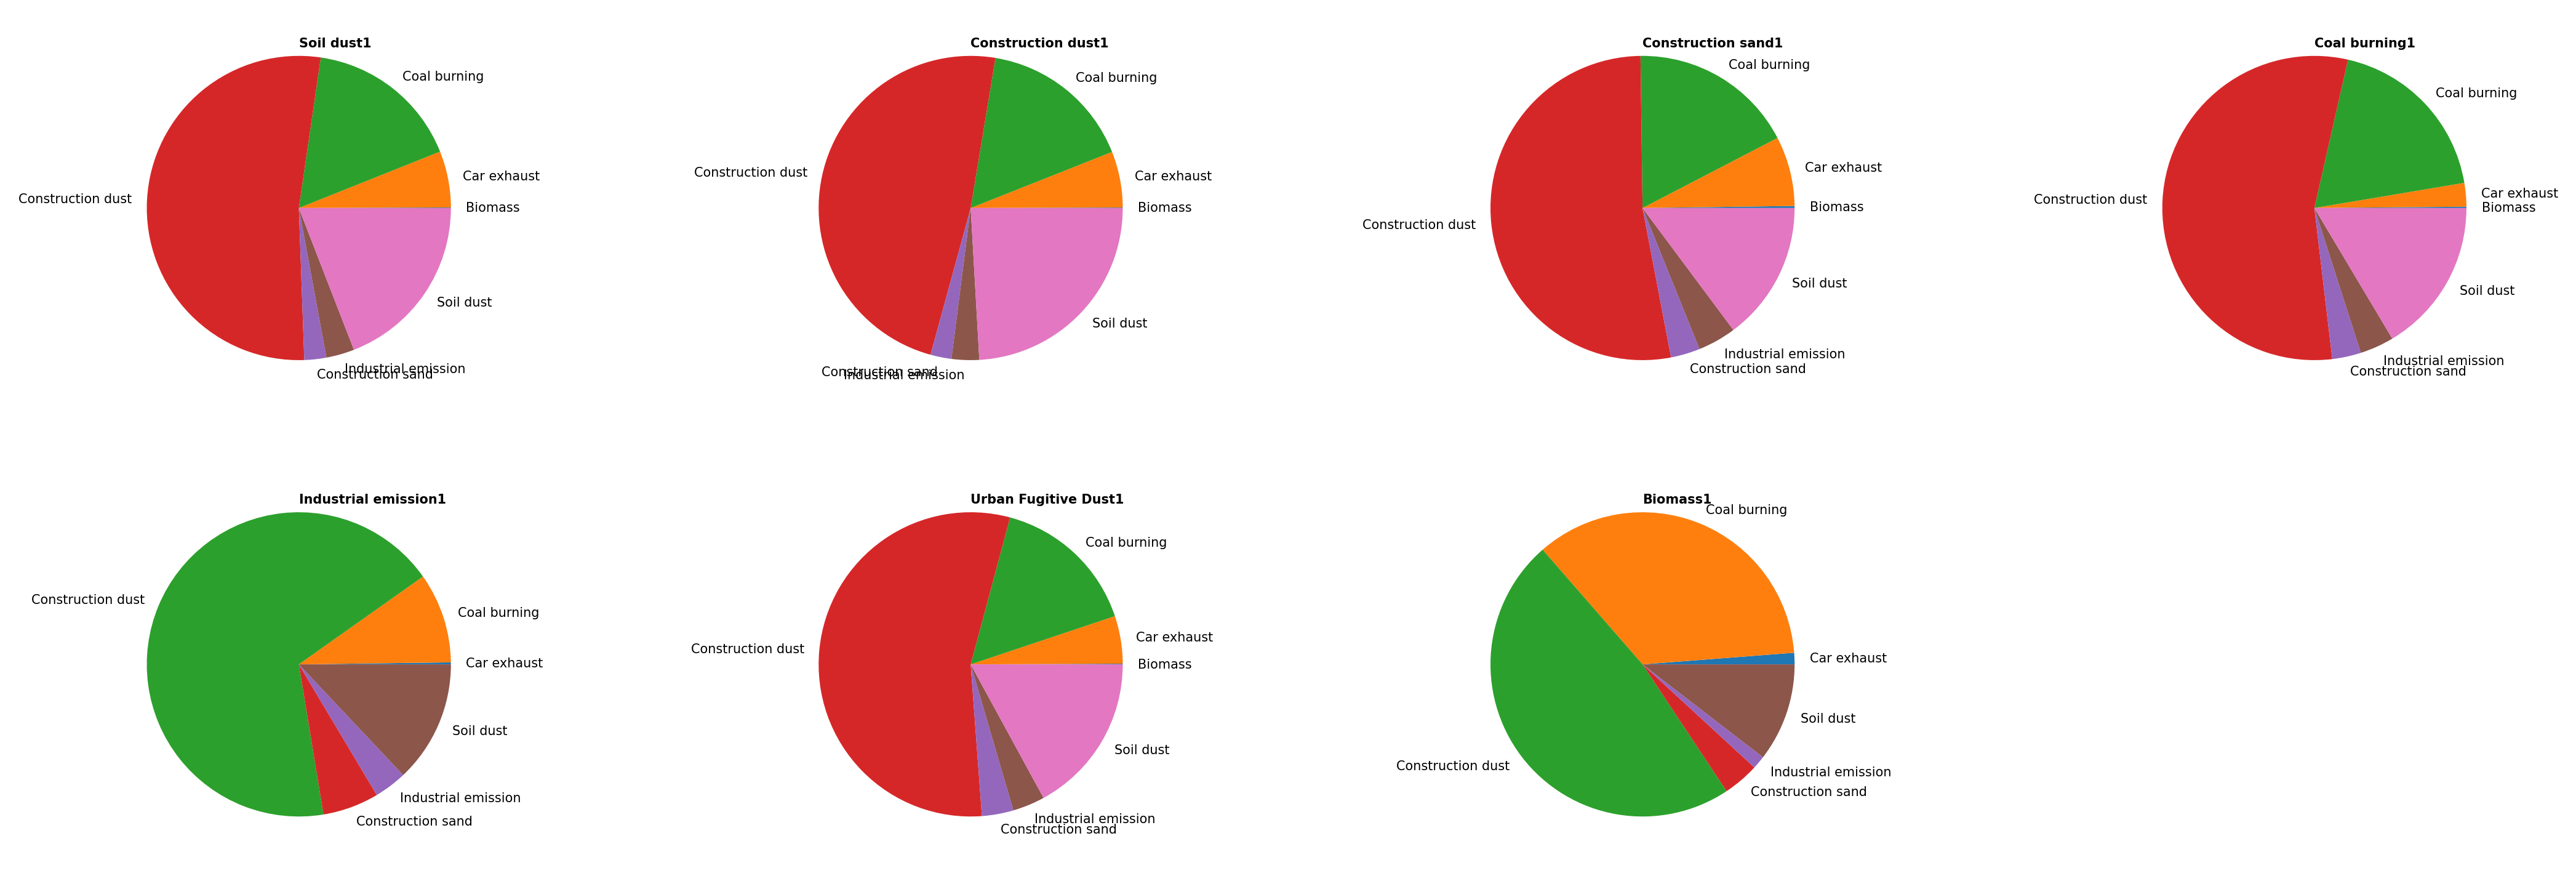

In [49]:
number = np.arange(0, 7, 1)
fig = plt.figure(figsize = (18,6), dpi = 300)
for i, label in enumerate(Sourceexsamplekeys):
    ax = fig.add_subplot(2, 4, i+1)
    ax.pie(knearestneighborslist[i][1][1]/knearestneighborslist[i][1][1].sum(), labels = knearestneighborslist[i][1][0], textprops={'fontsize': 5})
    ax.text(0.5, 0.95, label, transform=ax.transAxes,
            fontsize=5, fontweight='bold', va='top')